In [ ]:
import pandas as pd
import pandas_gbq
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
from os import environ
from google.cloud import bigquery

PROJECT_ID: str = "ml-mps-trl-fldt08-p-e8e1"
LOCATION: str = "US"

client = bigquery.Client(project=PROJECT_ID, location=LOCATION)

/root/Projects/Mayo_Datathon/.venv/lib/python3.12/site-packages/google/auth/_default.py:76: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


## Analysis Functions

## Acquire the curated dataset

In [273]:
def load_curated_data() -> pd.DataFrame:
    with open(file="./ETL.sql", mode="r") as f:
        query = f.read()

    df = pandas_gbq.read_gbq(query, project_id=PROJECT_ID)

    if df is None:
        raise Exception("Failed to load curated data")

    return df


curated_data: pd.DataFrame = load_curated_data()
curated_data.head()

GenericGBQException: Reason: 403 POST https://bigquery.googleapis.com/bigquery/v2/projects/ml-mps-trl-fldt08-p-e8e1/queries?prettyPrint=false: Access Denied: Project ml-mps-trl-fldt08-p-e8e1: User does not have bigquery.jobs.create permission in project ml-mps-trl-fldt08-p-e8e1.

## Simple Restructuring

In [ ]:
# Remove untested patients
curated_data = curated_data[curated_data["max_troponin"] != None]

# Converting max_troponin to float by remoing none digit characters and converting to float
curated_data["max_troponin"] = (
    curated_data["max_troponin"].str.replace("[^0-9.]", "", regex=True).astype(float)
)

# Adding a normal (0) or abnormal (1) flag for troponin levels over 0.01
curated_data["abnormal_troponin"] = np.where(curated_data["max_troponin"] > 0.01, 1, 0)

curated_data.info()
curated_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3342 entries, 0 to 3341
Data columns (total 26 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   patientunitstayid          3342 non-null   Int64  
 1   hospitalid                 3342 non-null   Int64  
 2   unittype                   3342 non-null   object 
 3   unitadmitsource            3342 non-null   object 
 4   gender                     3342 non-null   object 
 5   ethnicity                  3342 non-null   object 
 6   unitdischargeoffset_hours  3342 non-null   float64
 7   max_troponin               3342 non-null   float64
 8   non_cardiac_patient        3342 non-null   Int64  
 9   expired                    3342 non-null   Int64  
 10  intubated                  3200 non-null   Int64  
 11  dialysis                   3200 non-null   Int64  
 12  vent                       3200 non-null   Int64  
 13  heartrate                  3200 non-null   Int64

,patientunitstayid,hospitalid,unittype,unitadmitsource,gender,ethnicity,unitdischargeoffset_hours,max_troponin,non_cardiac_patient,expired,...,meanbp,hematocrit,creatinine,glucose,albumin,bilirubin,wbc,bun,age,abnormal_troponin
0,242319,79,Med-Surg ICU,Direct Admit,Male,Caucasian,30.93,0.04,1,0,...,152.0,25.8,2.7,160.0,2.8,0.6,16.7,41.0,61,1
1,242319,79,Med-Surg ICU,Direct Admit,Male,Caucasian,30.93,0.04,1,0,...,152.0,25.8,2.7,160.0,2.8,0.6,16.7,41.0,61,1
2,243334,79,Med-Surg ICU,Direct Admit,Male,Caucasian,104.03,0.83,1,0,...,47.0,28.5,7.9,191.0,2.9,0.6,18.2,60.0,89,1
3,243334,79,Med-Surg ICU,Direct Admit,Male,Caucasian,104.03,0.83,1,0,...,47.0,28.5,7.9,191.0,2.9,0.6,18.2,60.0,89,1
4,243334,79,Med-Surg ICU,Direct Admit,Male,Caucasian,104.03,0.83,1,0,...,47.0,28.5,7.9,191.0,2.9,0.6,18.2,60.0,89,1


In [ ]:
def list_possible_values(column_name: str, df: pd.DataFrame) -> None:
    total_samples: int = len(df)
    unique_values = df[column_name].unique()
    print(f"{len(unique_values)} unique values for {column_name}")
    for value in unique_values:
        value_count: int = len(df[df[column_name] == value])
        print(f"- {value}: {value_count:,} ({value_count / total_samples * 100:.2f}%)")


def descriptive_statistics(column_name: str, df: pd.DataFrame) -> None:
    print(f"Descriptive statistics for {column_name}")
    print(df[column_name].describe())


def plot_nominal_distribution(column_name: str, df: pd.DataFrame) -> None:
    plt.rcParams["figure.figsize"] = (10, 6)
    sns.countplot(x=column_name, data=df, stat="percent")
    plt.title(f"{column_name} distribution".title())
    plt.show()


def plot_numeric_distribution(column_name: str, df: pd.DataFrame) -> None:
    plt.rcParams["figure.figsize"] = (10, 6)
    sns.boxplot(x=column_name, data=df)
    plt.title(f"{column_name} distribution".title())
    plt.show()


def plot_numeric_distribution_with_group(
    column_name: str, group_column_name: str, df: pd.DataFrame
) -> None:
    plt.rcParams["figure.figsize"] = (10, 6)
    sns.violinplot(x=column_name, hue=group_column_name, data=df)
    plt.title(f"{column_name} distribution by {group_column_name}".title())
    plt.show()

# Exploratory Data Analysis | Whole Sample

In [ ]:
total_samples: int = len(curated_data)
print(f"Total number of samples: {total_samples:,}")

abnormal_samples: int = len(curated_data[curated_data["abnormal_troponin"] == 1])
non_abnormal_samples: int = len(curated_data[curated_data["abnormal_troponin"] == 0])
print(f"Total number of abnormal samples: {abnormal_samples:,}")
print(f"Total number of non-abnormal samples: {non_abnormal_samples:,}")

Total number of samples: 3,342
Total number of abnormal samples: 2,143
Total number of non-abnormal samples: 1,199


## Nominal Variables


2 unique values for gender
- Male: 1,705 (51.02%)
- Female: 1,637 (48.98%)


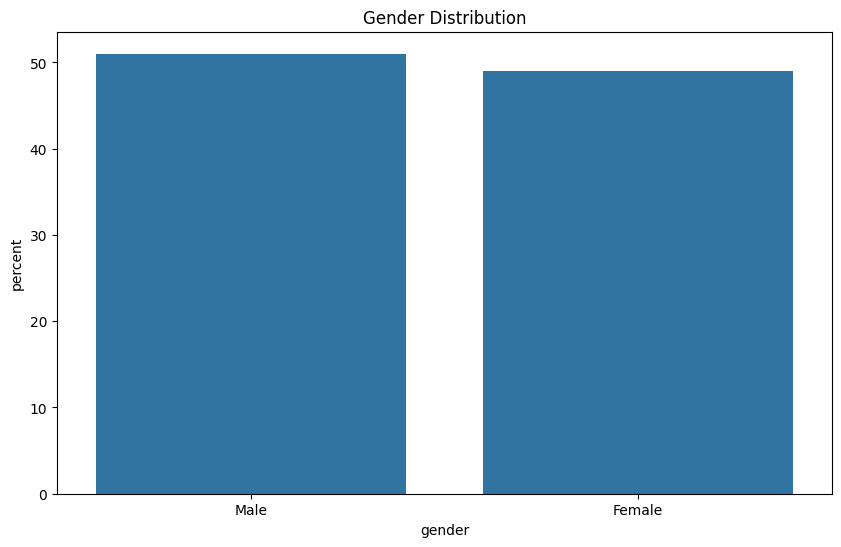


6 unique values for ethnicity
- Caucasian: 2,857 (85.49%)
- African American: 301 (9.01%)
- Other/Unknown: 101 (3.02%)
- Native American: 10 (0.30%)
- Asian: 37 (1.11%)
- Hispanic: 36 (1.08%)


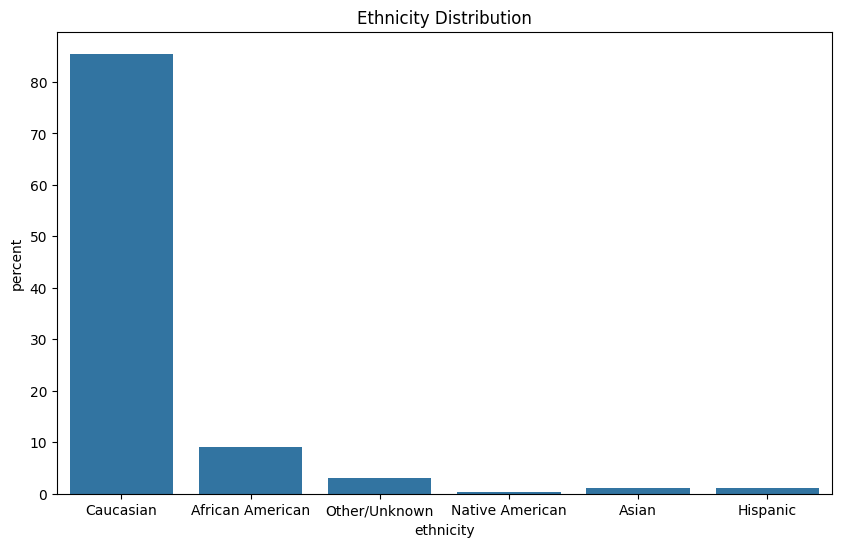


2 unique values for abnormal_troponin
- 1: 2,143 (64.12%)
- 0: 1,199 (35.88%)


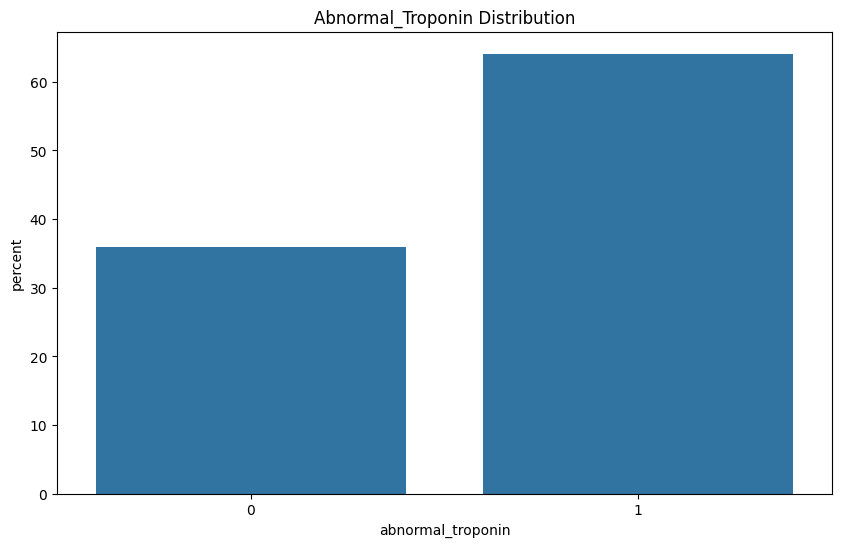


2 unique values for expired
- 0: 3,000 (89.77%)
- 1: 342 (10.23%)


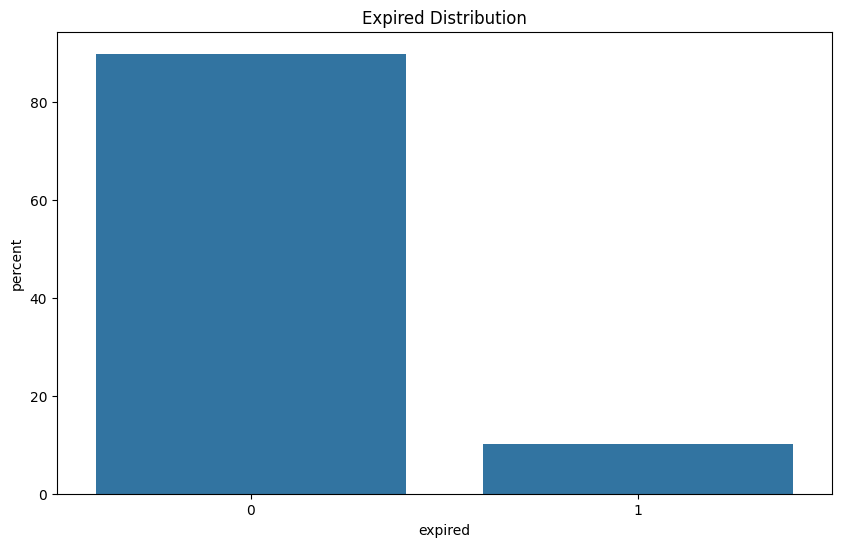

In [ ]:
for column_name in ["gender", "ethnicity", "abnormal_troponin", "expired"]:
    print()
    list_possible_values(column_name, curated_data)
    plot_nominal_distribution(column_name, curated_data)

## Numeric Variables


Descriptive statistics for max_troponin
count    3342.000000
mean        0.236872
std         0.892559
min         0.010000
25%         0.010000
50%         0.040000
75%         0.150000
max        25.000000
Name: max_troponin, dtype: float64


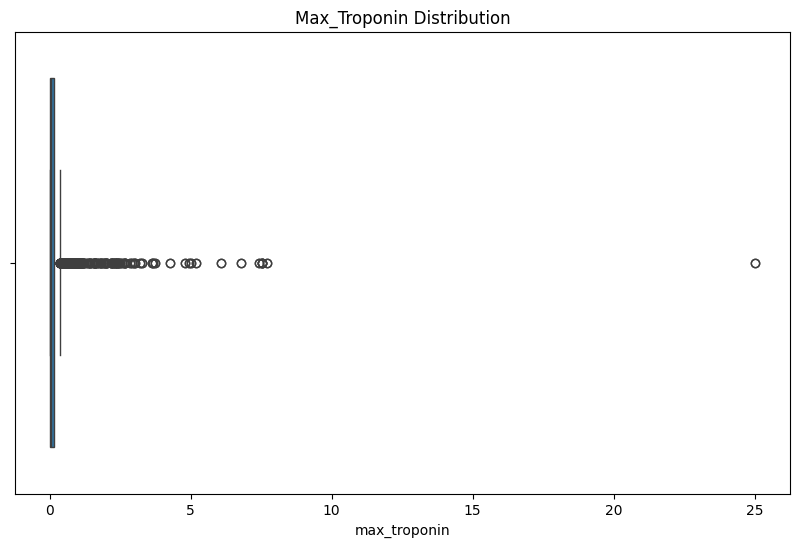


Descriptive statistics for age
count       3342.0
mean     66.545183
std       14.26588
min           18.0
25%           58.0
50%           68.0
75%           77.0
max           89.0
Name: age, dtype: Float64


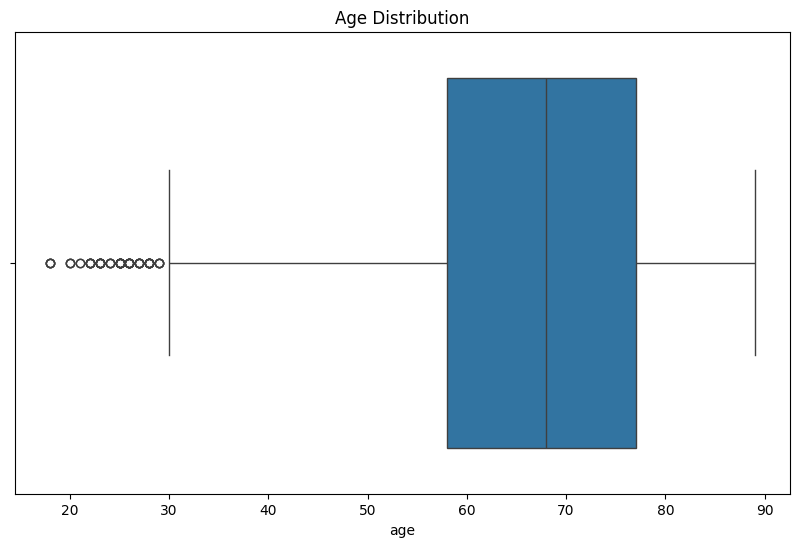

In [ ]:
for column_name in ["max_troponin", "age"]:
    print()
    descriptive_statistics(column_name, curated_data)
    plot_numeric_distribution(column_name, curated_data)

Average abnormal troponin level: 0.36
Average normal troponin level: 0.01


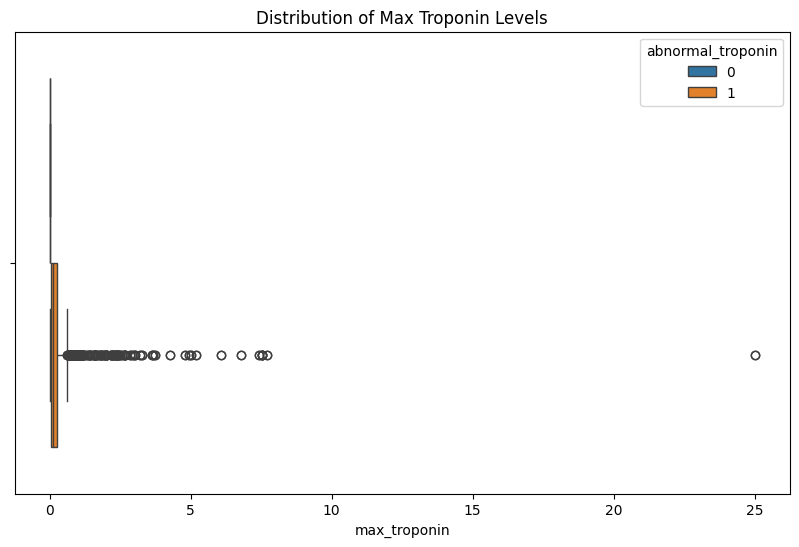

In [ ]:
avg_troponi_abnormal: float = curated_data[curated_data["abnormal_troponin"] == 1][
    "max_troponin"
].mean()
avg_troponi_normal: float = curated_data[curated_data["abnormal_troponin"] == 0][
    "max_troponin"
].mean()
print(f"Average abnormal troponin level: {avg_troponi_abnormal:.2f}")
print(f"Average normal troponin level: {avg_troponi_normal:.2f}")

sns.boxplot(x="max_troponin", hue="abnormal_troponin", data=curated_data)
plt.title("Distribution of Max Troponin Levels")
plt.show()

## Nominal Breakdowns

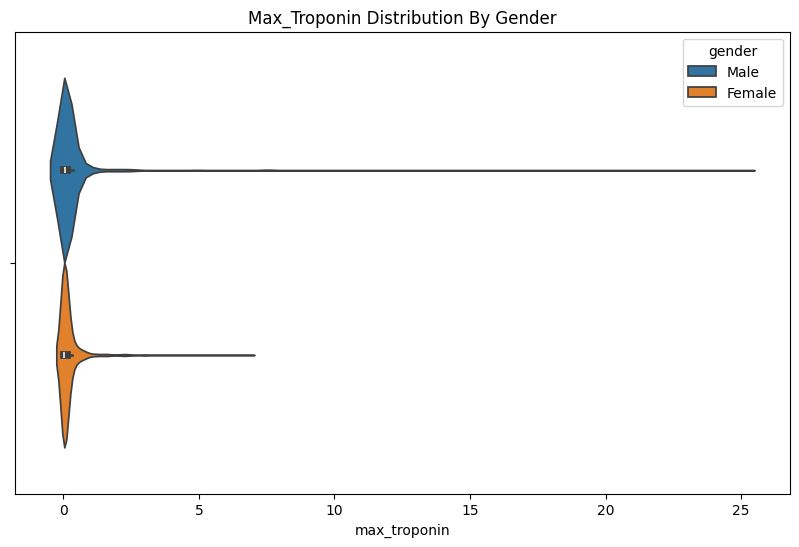

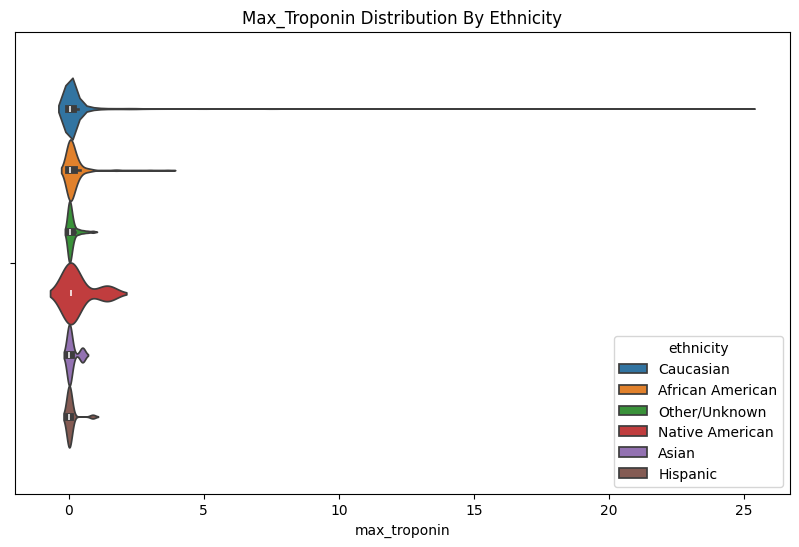

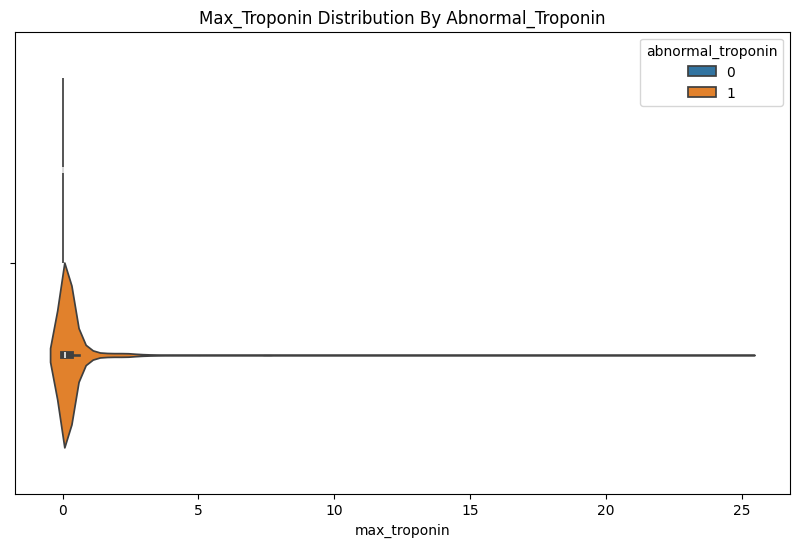

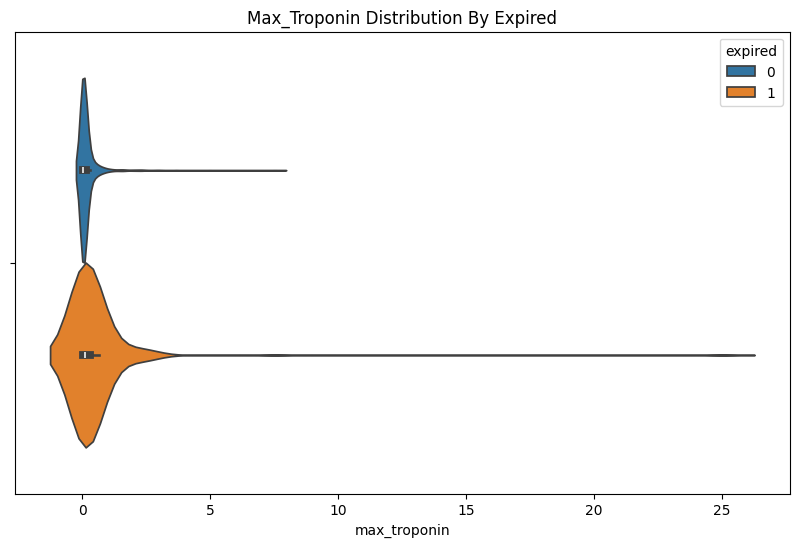

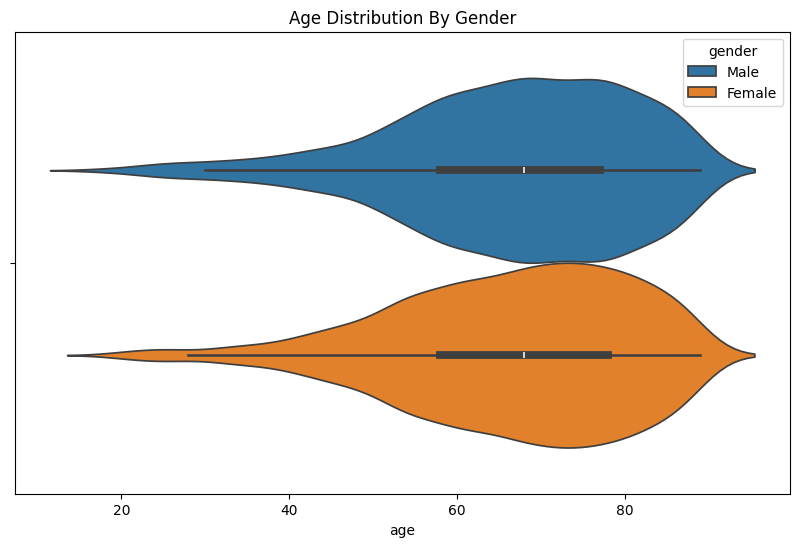

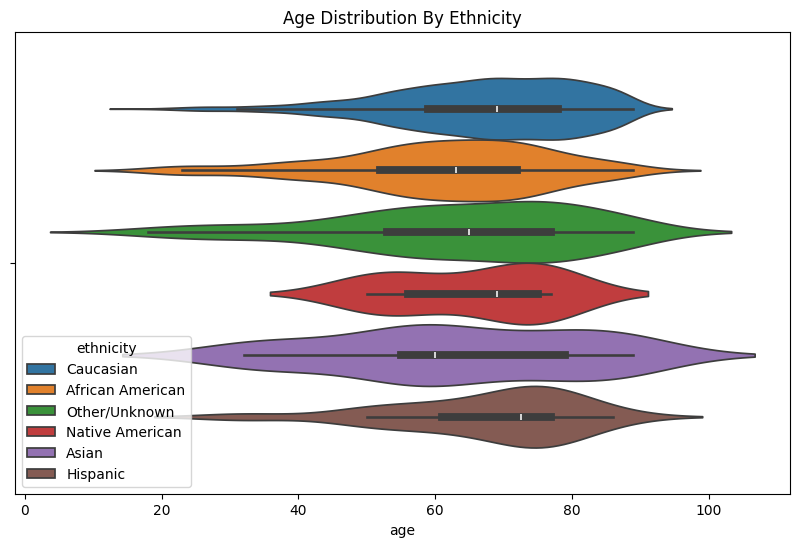

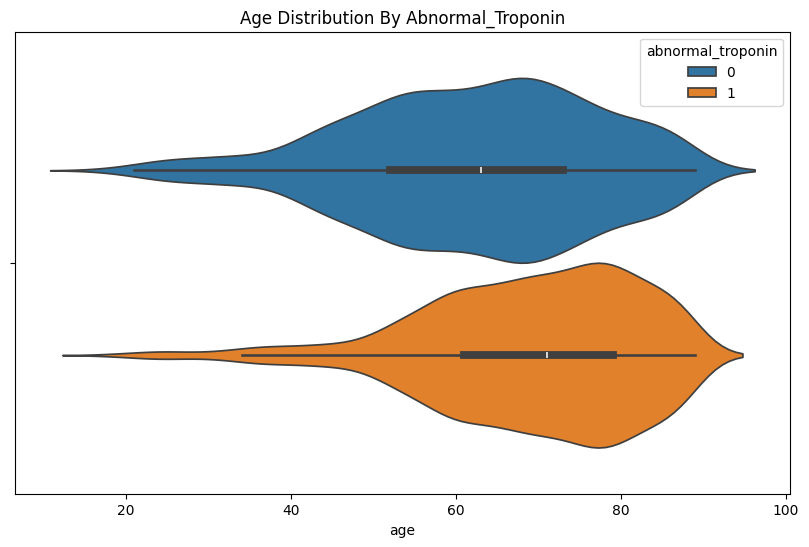

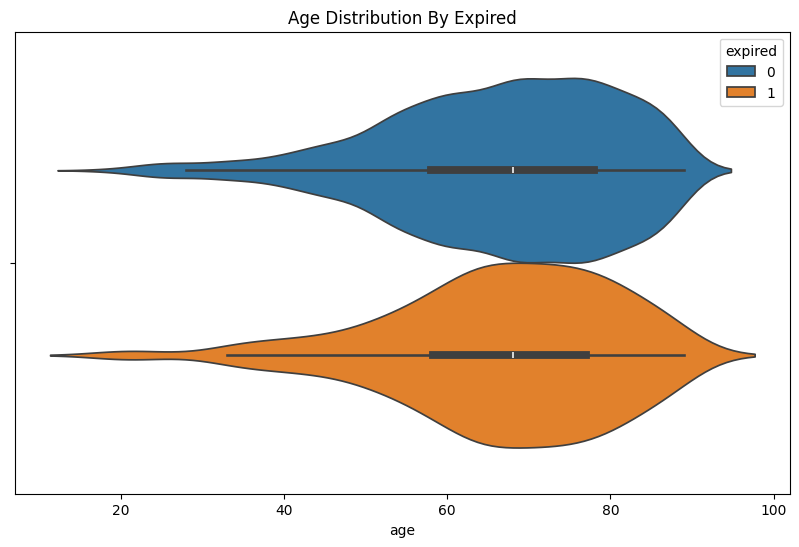

In [ ]:
for column_name in ["max_troponin", "age"]:
    for group_name in ["gender", "ethnicity", "abnormal_troponin", "expired"]:
        print()
        plot_numeric_distribution_with_group(column_name, group_name, curated_data)

# Statistical Testing

## Chi-Square

Tests if mortality rates differ significantly between normal vs. elevated troponin groups.

| | Expired | Alive |
| --- | --- | --- |
| Normal Troponin | $n_{00}$ | $n_{01}$ |
| Abnormal Troponin | $n_{10}$ | $n_{11}$ |

H<sub>0</sub>: There is no relationship between abnormal Troponin-T levels and patient outcome <br>
H<sub>1</sub>: There is a relationship between abnormal Troponin-T levels and patient outcome

alpha (&alpha;) = 0.05

In [ ]:
from scipy import stats

ALPHA: float = 0.05
ALPHA_STR: str = f"At a {ALPHA * 100}% significance level"

contingency_table = pd.crosstab(
    curated_data["abnormal_troponin"], curated_data["expired"], margins=True
)
chi2, p_value, dof, expected = stats.chi2_contingency(contingency_table)

print(f"Chi-square statistic: {chi2:.3f}")
print(f"Degrees of freedom: {dof}")
print(f"P-value: {p_value}")

if p_value < ALPHA:
    print(
        f"{ALPHA_STR}, there is a significant association between abnormal troponin and death."
    )
else:
    print(
        f"{ALPHA_STR}, there is no significant association between abnormal troponin and death."
    )

contingency_table

Chi-square statistic: 30.877
Degrees of freedom: 4
P-value: 3.2435303473189134e-06
At a 5.0% significance level, there is a significant association between abnormal troponin and death.


expired,0,1,All
abnormal_troponin,,,
0,1123,76,1199
1,1877,266,2143
All,3000,342,3342


## Odds Ratio

| | Expired | Alive |
| --- | --- | --- |
| Normal Troponin | $n_{00}$ | $n_{01}$ |
| Abnormal Troponin | $n_{10}$ | $n_{11}$ |

&pi;<sub>1</sub> = *P*[ Expired | Normal Troponin ] <br>
&pi;<sub>2</sub> = *P*[ Expired | Abnormal Troponin ]

In [ ]:
n00 = contingency_table.iloc[0, 0]
n01 = contingency_table.iloc[0, 1]
n10 = contingency_table.iloc[1, 0]
n11 = contingency_table.iloc[1, 1]
n = n00 + n01 + n10 + n11

pi_1: float = (n01 / n) / (1 - (n01 / n))
pi_2: float = (n11 / n) / (1 - (n11 / n))

odds_ratio: float = pi_1 / pi_2
est_odds_ratio: float = (n00 + n11) / (n01 + n10)

print(f"pi_1: {pi_1:.3f}")
print(f"pi_2: {pi_2:.3f}")
print(f"Calculated Odds Ratio: {odds_ratio:.3f}")
print(f"Approximate Odds Ratio: {est_odds_ratio:.3f}")

pi_1: 0.023
pi_2: 0.086
Calculated Odds Ratio: 0.269
Approximate Odds Ratio: 0.711


## Logistic Regression

Quantifies how much elevated troponin increases mortality risk.

H<sub>0</sub>: Troponin-T does not predict mortality <br>
H<sub>1</sub>: Troponin-T predicts mortality

alpha (&alpha;) = 0.05

Number of samples: 3200
Accuracy: 0.89
ROC AUC: 0.73

                  0.0        1.0  accuracy   macro avg  weighted avg
precision    0.893082   0.250000  0.889062    0.571541      0.823750
recall       0.994746   0.014493  0.889062    0.504619      0.889062
f1-score     0.941176   0.027397  0.889062    0.484287      0.842660
support    571.000000  69.000000  0.889062  640.000000    640.000000

                      feature  coefficient  odds_ratio
0                max_troponin     0.182285    1.199956
1           abnormal_troponin     0.538831    1.714002
2                         age     0.002900    1.002904
3   unitdischargeoffset_hours     0.000340    1.000340
4                   intubated     0.395127    1.484572
5                    dialysis    -0.139304    0.869964
6                        vent     0.737571    2.090850
7                   heartrate     0.014235    1.014337
8                 temperature    -0.050754    0.950513
9                      sodium    -0.001478    0.99

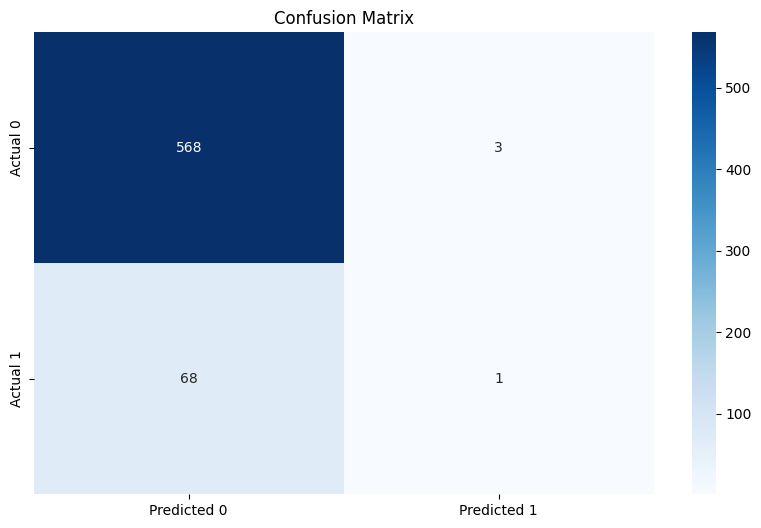

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
)

PREDICTORS: list[str] = [
    "max_troponin",
    "abnormal_troponin",
    "age",
    "unitdischargeoffset_hours",
    "intubated",
    "dialysis",
    "vent",
    "heartrate",
    "temperature",
    "sodium",
    "meanbp",
    "hematocrit",
    "creatinine",
    "glucose",
    "albumin",
    "bilirubin",
    "wbc",
    "bun"
]

regression_df = curated_data.copy()
regression_df.dropna(inplace=True)
print(f"Number of samples: {len(regression_df)}")

X = regression_df[PREDICTORS]
y = regression_df["expired"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model = LogisticRegression(max_iter=5000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

y_pred_proba = model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC AUC: {roc_auc:.2f}")

confusion_matrix_df = pd.DataFrame(
    confusion_matrix(y_test, y_pred),
    columns=["Predicted 0", "Predicted 1"],
    index=["Actual 0", "Actual 1"],
)
classification_report_df = pd.DataFrame(
    classification_report(y_test, y_pred, output_dict=True, zero_division=1)
)
coefficients_df = pd.DataFrame(
    {"feature": X.columns, "coefficient": model.coef_[0], "odds_ratio": np.exp(model.coef_[0])}
)

print(f"\n{classification_report_df}")
print(f"\n{coefficients_df}")

plt.figure(figsize=(10, 6))
sns.heatmap(confusion_matrix_df, annot=True, cmap="Blues", fmt="g")
plt.title("Confusion Matrix")
plt.show()